In [1]:
!pip install --upgrade pip
!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install jax
!pip install jaxlib diffusers huggingface_hub flax transformers
!pip install orbax-checkpoint
!pip install -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00:00:010:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
!pip show diffusers

Name: diffusers
Version: 0.25.1
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: patrick@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 


In [3]:
from diffusers import FlaxUNet2DConditionModel
from IPython.display import clear_output

loaded_model = FlaxUNet2DConditionModel.from_pretrained('ekhalavyan/sdxl-unet')
clear_output(wait=False) # Clear the loading messages
unet_base_module = loaded_model[0] # Extract the Flax Module
# unet_variables = {'params': diff_unet[1]} # Extract the parameters

# print(unet_variables.keys())
unet_base_module

FlaxUNet2DConditionModel(
    # attributes
    sample_size = 128
    in_channels = 4
    out_channels = 4
    down_block_types = ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']
    up_block_types = ['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']
    only_cross_attention = False
    block_out_channels = [320, 640, 1280]
    layers_per_block = 2
    attention_head_dim = [5, 10, 20]
    num_attention_heads = None
    cross_attention_dim = 2048
    dropout = 0.0
    use_linear_projection = True
    dtype = float32
    flip_sin_to_cos = True
    freq_shift = 0
    use_memory_efficient_attention = False
    split_head_dim = False
    transformer_layers_per_block = [1, 2, 10]
    addition_embed_type = 'text_time'
    addition_time_embed_dim = 256
    addition_embed_type_num_heads = 64
    projection_class_embeddings_input_dim = 2816
)

In [4]:
import jax
import numpy as np
import jax.numpy as jnp
import orbax.checkpoint

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Union
import requests
import time
from io import BytesIO

from diffusers.utils import PIL_INTERPOLATION
from diffusers.schedulers.scheduling_utils_flax import broadcast_to_shape_from_left

from safetensors.numpy import load_file

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
import transformers
from diffusers.utils.pil_utils import numpy_to_pil
from diffusers.utils import make_image_grid
from huggingface_hub import hf_hub_download

In [5]:
sdxl_params = {}
dtype = jnp.bfloat16

In [6]:
sdxl_params['base_unet'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), loaded_model[1])}

In [7]:
loaded_model = load_file("/kaggle/input/sdxl-refiner-unet/diffusion_pytorch_model.safetensors")
flax_model = dict()
lookup_list = ['.0', '.1' ,'.2', '.3' ,'.4' ,'.5', '.6', '.7', '.8' ,'.9']
for key, value in loaded_model.items():
    for check_str in lookup_list:                                                                                                                                                                                                         
        key = key.replace(check_str,'_'+check_str[-1])
    
    keys = key.replace('weight','kernel').split('.')
    
    current = flax_model
    for x in keys:
        if x in current.keys():
            if x == keys[-1]:
                if x == 'kernel':
                    current[x] = value.T
                else:
                    current[x] = value
                    
            current = current[x]
        elif x == keys[-1]:
            if x == 'kernel':
                current[x] = value.T
            else:
                current[x] = value
        else:
            current[x] = {}        
            current = current[x]
            
flax_model.keys()

dict_keys(['add_embedding', 'conv_in', 'conv_norm_out', 'conv_out', 'down_blocks_0', 'down_blocks_1', 'down_blocks_2', 'down_blocks_3', 'mid_block', 'time_embedding', 'up_blocks_0', 'up_blocks_1', 'up_blocks_2', 'up_blocks_3'])

In [8]:
sdxl_params['refiner_unet'] = {'params': jax.tree_map(lambda x: x.astype(dtype), flax_model)}
del flax_model

In [9]:
unet_refiner_module = FlaxUNet2DConditionModel.from_config('/kaggle/input/sdxl-refiner-unet')
unet_refiner_module

/usr/local/lib/python3.10/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


FlaxUNet2DConditionModel(
    # attributes
    sample_size = 128
    in_channels = 4
    out_channels = 4
    down_block_types = ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D']
    up_block_types = ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']
    only_cross_attention = False
    block_out_channels = [384, 768, 1536, 1536]
    layers_per_block = 2
    attention_head_dim = [6, 12, 24, 24]
    num_attention_heads = None
    cross_attention_dim = 1280
    dropout = 0.0
    use_linear_projection = True
    dtype = float32
    flip_sin_to_cos = True
    freq_shift = 0
    use_memory_efficient_attention = False
    split_head_dim = False
    transformer_layers_per_block = 4
    addition_embed_type = 'text_time'
    addition_time_embed_dim = 256
    addition_embed_type_num_heads = 64
    projection_class_embeddings_input_dim = 2560
)

In [10]:
FlaxUNet2DConditionModel

diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel

In [11]:
from transformers import CLIPTokenizer
tokenizer_1 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
tokenizer_2 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32') 

In [12]:
from transformers import FlaxCLIPTextModel, FlaxCLIPTextModelWithProjection
text_encoder_1 = FlaxCLIPTextModel.from_pretrained('/kaggle/input/sdxl-text-encoder-1')
text_encoder_2 = FlaxCLIPTextModelWithProjection.from_pretrained('/kaggle/input/text-encoder-2')

In [13]:
sdxl_params['text_encoder_1'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), text_encoder_1.params)}
sdxl_params['text_encoder_2'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), text_encoder_2.params)}

In [14]:
refiner_text_encoder_2 = FlaxCLIPTextModelWithProjection.from_pretrained('/kaggle/input/sdxl-refiner-tokenizer2')
sdxl_params['refiner_text_encoder_2'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), refiner_text_encoder_2.params)}
print("sdxl_params_reiner_texenc2:", sdxl_params['text_encoder_2']['params']['text_model']['embeddings']['position_embedding']['embedding'].shape)

sdxl_params_reiner_texenc2: (77, 1280)


In [45]:
sdxl_params['text_encoder_2']['params']['text_model']['encoder']['layers'].keys()

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '4', '5', '6', '7', '8', '9'])

In [15]:
from diffusers import FlaxAutoencoderKL
from IPython.display import clear_output

loaded_model = FlaxAutoencoderKL.from_pretrained('ekhalavyan/sdxl-vae')
clear_output(wait=False) # Clear the loading messages
vae_module = loaded_model[0] # Extract the Flax Module
# vae_variables = {'params': diff_vae[1]} # Extract the parameters

sdxl_params['vae'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), loaded_model[1])}

# print(vae_variables.keys())
vae_module

FlaxAutoencoderKL(
    # attributes
    in_channels = 3
    out_channels = 3
    down_block_types = ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D']
    up_block_types = ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']
    block_out_channels = [128, 256, 512, 512]
    layers_per_block = 2
    act_fn = 'silu'
    latent_channels = 4
    norm_num_groups = 32
    sample_size = 1024
    scaling_factor = 0.13025
    dtype = float32
)

In [16]:
from diffusers import FlaxEulerDiscreteScheduler
loaded_model = FlaxEulerDiscreteScheduler.from_pretrained('/kaggle/input/sdxl-scheduler/config.json')
scheduler_module = loaded_model[0]
scheduler_params = loaded_model[1]
sdxl_params['scheduler'] = {'params': loaded_model[1]}

In [17]:
loaded_model = 5

In [18]:
vae_scale_factor = 2 ** (len(vae_module.config.block_out_channels) - 1)
height = unet_base_module.config.sample_size * vae_scale_factor
width = unet_base_module.config.sample_size * vae_scale_factor

In [19]:
unet_base_module.config.sample_size * vae_scale_factor //2

512

In [20]:
guidance_scale = 5.0
num_steps = 100
default_seed = 33
strength = 0.3

In [21]:
# prng_seed = jax.random.PRNGKey(default_seed)
# init_latent_dist = vae_module.apply(sdxl_params['vae'], processed_images, method=vae_module.encode).latent_dist
# init_latents = init_latent_dist.sample(key=prng_seed).transpose((0, 3, 1, 2))
# print(init_latents.min(), init_latents.max())
# latents = vae_module.config.get("scaling_factor") * init_latents
# print(latents.min(), latents.max())
# noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
# latent_timestep = scheduler_state.timesteps[num_steps-start_timestep].astype(int)
# latents = scheduler_module.add_noise(sdxl_params['scheduler']['params'], init_latents, noise, latent_timestep)
# print(latent_timestep, latents.min(), latents.max())
# latents = strength*latents + (1-strength)*noise
# print(latents.min(), latents.max())
# new_latents = noise * scheduler_state.init_noise_sigma
# print(new_latents.min(), new_latents.max())

In [22]:
# start_timestep, scheduler_state.timesteps[num_steps-start_timestep], scheduler_params.sigmas[scheduler_state.timesteps[num_steps-start_timestep].astype(int)]

# Old Code

In [23]:
@partial(
    jax.pmap,
    in_axes=(0, 0, 0, 0, 0, 0, None, None),
    static_broadcasted_argnums=(6, 7),
)
def generate_image(
    sdxl_params,
    positive_input_ids,
    negative_input_ids=None,
    p_processed_image = None,
    prng_seed=jax.random.PRNGKey(42),
    strength=jnp.arange(0.875,0.925,(0.925-0.875)/8.0),
    guidance_scale=5.0,
    num_inference_steps=50
):
    print(positive_input_ids.shape)
    
    def get_embeddings(prompt_ids):
        print(prompt_ids.shape)
        te_1_inputs = prompt_ids[:, 0, :]
        te_2_inputs = prompt_ids[:, 1, :]
        
        print(te_1_inputs.shape, te_2_inputs.shape)
        print("sdxl_params:", sdxl_params['text_encoder_1']['params']['text_model']['embeddings']['position_embedding']['embedding'].shape)
        
        prompt_embeds_1 = text_encoder_1(te_1_inputs,params=sdxl_params['text_encoder_1']['params'], output_hidden_states=True)["hidden_states"][-2]
        prompt_embeds_2 = text_encoder_2(te_2_inputs,params=sdxl_params['text_encoder_2']['params'], output_hidden_states=True)["hidden_states"][-2]

        prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)
        pooled_embeds = text_encoder_2(te_2_inputs,params=sdxl_params['text_encoder_2']['params'], output_hidden_states=True)["text_embeds"]
        
        return prompt_embeds, pooled_embeds
    
    positive_prompt_embeds, positive_pooled_embeds = get_embeddings(positive_input_ids)
    batch_size = positive_prompt_embeds.shape[0]
    
    if negative_input_ids is None:
        negative_prompt_embeds = jnp.zeros_like(positive_prompt_embeds)
        negative_pooled_embeds = jnp.zeros_like(positive_pooled_embeds)
    else:       
        negative_prompt_embeds, negative_pooled_embeds = get_embeddings(negative_input_ids)
        
    prompt_embeds = jnp.concatenate([negative_prompt_embeds, positive_prompt_embeds], axis=0)  # (2, 77, 2048)
    print(prompt_embeds.shape, positive_prompt_embeds.dtype)
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    latents_shape = (
                batch_size,
                unet_base_module.config.in_channels,
                height // vae_scale_factor,
                width // vae_scale_factor,
            )
    
    scheduler_state = scheduler_module.set_timesteps(sdxl_params['scheduler']['params'], num_inference_steps=num_inference_steps, shape=latents_shape)
    
    def get_timestep_start(num_inference_steps, strength):
    # get the original timestep using init_timestep
#         init_timestep = min((num_inference_steps * strength).astype(int), num_inference_steps)

        t_start = num_inference_steps - (num_inference_steps * strength).astype(int)

        return t_start
    
    start_timestep = get_timestep_start(num_steps, strength)
    
    if p_processed_image is not None:
        init_latent_dist = vae_module.apply(sdxl_params['vae'], p_processed_image, method=vae_module.encode).latent_dist
        init_latents = init_latent_dist.sample(key=prng_seed).transpose((0, 3, 1, 2))
        latents = vae_module.config.get("scaling_factor") * init_latents
        noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
        latent_timestep = scheduler_state.timesteps[num_inference_steps-start_timestep].astype(int)
        sigma = sdxl_params['scheduler']['params'].sigmas[latent_timestep-1]
        sigma = broadcast_to_shape_from_left(sigma, noise.shape)
        latents = (1-strength)*sigma*latents + strength*sigma*noise # scheduler_module.add_noise(sdxl_params['scheduler']['params'], init_latents, noise, latent_timestep) # 
    else:
        latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
        latents = latents * scheduler_state.init_noise_sigma
        
    
#     print(latents.shape)
    
    def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
        return add_time_ids
    
    add_time_ids = _get_add_time_ids(
        (height, width), (0, 0), (height, width), positive_prompt_embeds.shape[0], dtype=positive_prompt_embeds.dtype
    )
    
    add_text_embeds = jnp.concatenate([negative_pooled_embeds, positive_pooled_embeds], axis=0)
    add_time_ids = jnp.concatenate([add_time_ids, add_time_ids], axis=0)
    
    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
#     print(prompt_embeds.shape)x
    def base_loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)
        
        print(latents_input.shape)

        # predict the noise residual
        noise_pred = unet_base_module.apply(
            sdxl_params['base_unet'],
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state
    
    latents, _ = jax.lax.fori_loop(start_timestep, num_inference_steps, base_loop_body, (latents, scheduler_state))
    
    ############################################ End of base model #####################################################################
    
    def get_refiner_embeddings(prompt_ids):
        te_1_inputs = prompt_ids[:, 0, :]
        te_2_inputs = prompt_ids[:, 1, :]

        prompt_embeds_1 = text_encoder_1(te_1_inputs,params=sdxl_params['text_encoder_1']['params'], output_hidden_states=True)["hidden_states"][-2]
        prompt_embeds_2 = refiner_text_encoder_2(te_2_inputs,params=sdxl_params['refiner_text_encoder_2']['params'], output_hidden_states=True)["hidden_states"][-2]

        prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)
        pooled_embeds = refiner_text_encoder_2(te_2_inputs,params=sdxl_params['refiner_text_encoder_2']['params'], output_hidden_states=True)["text_embeds"]

        return prompt_embeds, pooled_embeds
    
    positive_refiner_prompt_embeds, positive_refiner_pooled_embeds = get_embeddings(positive_input_ids)
    batch_size = positive_refiner_prompt_embeds.shape[0]
    
    if negative_input_ids is None:
        negative_refiner_prompt_embeds = jnp.zeros_like(positive_refiner_prompt_embeds)
        negative_refiner_pooled_embeds = jnp.zeros_like(positive_refiner_pooled_embeds)
    else:       
        negative_refiner_prompt_embeds, negative_refiner_pooled_embeds = get_embeddings(negative_input_ids)
    
    prompt_refiner_embeds = jnp.concatenate([negative_refiner_prompt_embeds, positive_refiner_prompt_embeds], axis=0)  # (2, 77, 2048)
    
    add_refiner_time_ids = _get_add_time_ids(
        (height, width), (0, 0), (height, width), positive_refiner_prompt_embeds.shape[0], dtype=positive_refiner_prompt_embeds.dtype
    )
    
    add_refiner_text_embeds = jnp.concatenate([negative_refiner_pooled_embeds, positive_refiner_pooled_embeds], axis=0)
    add_refiner_time_ids = jnp.concatenate([add_refiner_time_ids, add_refiner_time_ids], axis=0)
    
    added_refiner_cond_kwargs = {"text_embeds": add_refiner_text_embeds, "time_ids": add_refiner_time_ids}    
    
    def refiner_loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)
        print("timestep: ", (jnp.array(timestep, dtype=jnp.int32)))
        # predict the noise residual
        noise_pred = unet_refiner_module.apply(
            sdxl_params['refiner_unet'],
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_refiner_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state
        
    
    scheduler_state = scheduler_module.set_timesteps(sdxl_params['scheduler']['params'], num_inference_steps=num_inference_steps, shape=latents_shape)
    
    latents, _ = jax.lax.fori_loop(start_timestep, num_inference_steps, refiner_loop_body, (latents, scheduler_state))
    
#     latents = latents/scheduler_state.init_noise_sigma
    latents = 1 / vae_module.config.get("scaling_factor") * latents
    
    image = vae_module.apply(sdxl_params['vae'], latents, method=vae_module.decode).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    
    return image

In [24]:
def tokenise_prompts(prompt):
    inputs = []
    for tokenizer in [tokenizer_1, tokenizer_2]:
        text_inputs = tokenizer(
            positive_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        inputs.append(text_inputs.input_ids)
    return jnp.stack(inputs, axis=1)

In [25]:
def preprocess(image, dtype):
    w, h = image.size
    if w>h:
        image = image.crop((0.25*w,0,0.25*w+h,h))
    else:
        image = image.crop((0,0,w,w))        
#     print(w,h)
#     w, h = (x - x % 32 for x in (h, h))  # resize to integer multiple of 32
    image = image.resize((1024, 1024), resample=PIL_INTERPOLATION["lanczos"])
    image = jnp.array(image).astype(dtype) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    return 2.0 * image - 1.0

(1, 3, 1024, 1024)


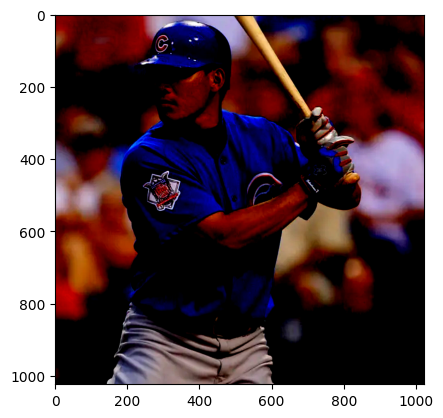

In [26]:
url = "https://cdn.vox-cdn.com/thumbor/JFRMyKpqXDf9AzCLwkXkameOKPA=/166x619:2000x2797/920x613/filters:focal(912x677:1232x997):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/72951367/123951100.0.jpg"
response = requests.get(url)
processed_images = preprocess(Image.open(BytesIO(response.content)).convert("RGB"), jnp.float32)
print(processed_images.shape)
plt.imshow(processed_images[0].transpose(1,2,0))

In [27]:
positive_prompt = "Boy dressed in green hitting with a baseball bat. Realistic. portrait, 80mm lens, shallow depth of field, close up, split lighting, cinematic"
negative_prompt = None
prng_seed = replicate(jax.random.PRNGKey(default_seed))
positive_input_ids = replicate(tokenise_prompts(positive_prompt))
sdxl_params = replicate(sdxl_params)
p_processed_image = replicate(processed_images)
strength = jnp.arange(0.80,0.875,(0.875-0.80)/8.0)
# prng_seed = jax.random.PRNGKey(default_seed)
# positive_input_ids = tokenise_prompts(positive_prompt)
print(positive_input_ids.shape)

XlaRuntimeError: RESOURCE_EXHAUSTED: Error allocating device buffer: Attempting to allocate 81.00M. That was not possible. There are 78.23M free.; (0x0x0_HBM0)

In [ ]:
print("Start Compiling")
start = time.time()
gen_image = generate_image(sdxl_params, positive_input_ids, negative_prompt, p_processed_image, prng_seed, strength, guidance_scale, num_steps)
print(f"Compiled in {time.time() - start}")

# convert the images to PIL
output_images = numpy_to_pil(np.array((gen_image.reshape((gen_image.shape[0] * gen_image.shape[1], ) + gen_image.shape[-3:]))))
make_image_grid(output_images, 2, 4)

# figsize=(10,10)
# # key = jax.random.PRNGKey(42)
# # test_image = jax.random.normal(key, shape=(1024,1024, 3))
# # test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")

# plt.figure(figsize=figsize)
# plt.axis('off')
# # plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
# plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [ ]:
positive_prompt = '''A cinematic film still of Morgan Freeman dressed in yellow with a baseball bat, portrait, 80mm lens, shallow depth of field, close up, split lighting, cinematic'''
positive_input_ids = replicate(tokenise_prompts(positive_prompt))
strength = jnp.arange(0.80,0.875,(0.875-0.80)/8.0)

In [ ]:
jnp.arange(0.875,0.925,(0.925-0.875)/8.0)

In [ ]:
print("Start Compiling")
start = time.time()
gen_image = generate_image(sdxl_params, positive_input_ids, negative_prompt, p_processed_image, prng_seed, strength, guidance_scale, num_steps)
print(f"Compiled in {time.time() - start}")
output_images = numpy_to_pil(np.array((gen_image.reshape((gen_image.shape[0] * gen_image.shape[1], ) + gen_image.shape[-3:]))))
make_image_grid(output_images, 2, 4)

# figsize=(10,10)
# # key = jax.random.PRNGKey(42)
# # test_image = jax.random.normal(key, shape=(1024,1024, 3))
# # test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")

# plt.figure(figsize=figsize)
# plt.axis('off')
# # plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
# plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [ ]:
sdgdfg

In [ ]:
unet_refiner_module.addition_embed_type

In [ ]:
scheduler_state = scheduler_module.set_timesteps(
        scheduler_params, num_inference_steps=num_steps, shape=(1,4,128,128)
)

In [ ]:
 def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
        return add_time_ids

time_ids = _get_add_time_ids(
        (height, width), (0, 0), (height, width), 1, dtype=jnp.float32
    )
    
time_ids = jnp.concatenate([time_ids, time_ids], axis=0)

In [ ]:
from diffusers.models.unet_2d_condition_flax import FlaxTimesteps, FlaxTimestepEmbedding
from diffusers.models.embeddings_flax import get_sinusoidal_embeddings
time_proj = FlaxTimesteps(unet_refiner_module.addition_time_embed_dim,unet_refiner_module.flip_sin_to_cos,unet_refiner_module.freq_shift)
time_emb = get_sinusoidal_embeddings(jnp.ravel(time_ids),unet_refiner_module.addition_time_embed_dim,unet_refiner_module.flip_sin_to_cos,unet_refiner_module.freq_shift+1)
time_emb.shape

In [ ]:
time_embedding = FlaxTimestepEmbedding(unet_refiner_module.block_out_channels[0], dtype=unet_refiner_module.dtype)

In [ ]:
unet_refiner_module.dtype

In [ ]:
from flax import linen as nn  # Linen API

model_temb = nn.Dense(1536, dtype=jnp.float32, name="linear_1")
mod_params = {'params': {'kernel': sdxl_params['refiner_unet']['params']['add_embedding']['linear_1']['kernel'][0],
                       'bias': sdxl_params['refiner_unet']['params']['add_embedding']['linear_1']['bias'][0],
                      }
             }

model_temb.apply(mod_params,time_emb)

In [ ]:
import flax
serialised_params = flax.serialization.msgpack_serialize(ref_unet_pytree, in_place=False)

In [ ]:
import msgpack

# Write msgpack file
with open("data.msgpack", "wb") as outfile:
    packed = msgpack.packb(serialised_params)
    outfile.write(packed)

In [ ]:
type((np.array([1,2,3])).astype(list))

In [ ]:
sdxl_params['base_unet']['params']['add_embedding']['linear_1']['kernel'].shape

In [ ]:
sdxl_params['refiner_unet']['params']['add_embedding']['linear_1']['kernel'].shape

In [ ]:
jax.random.normal(jax.random.PRNGKey(561),(1,2816,1280))@jax.random.normal(jax.random.PRNGKey(23),(1,4,128,128))